## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames


# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent =float(n_greater_50k / n_records *100)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

In [3]:
income_raw = data['income']
income_raw.head(100)

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
5     <=50K
6     <=50K
7      >50K
8      >50K
9      >50K
10     >50K
11     >50K
12    <=50K
13    <=50K
14    <=50K
15    <=50K
16    <=50K
17    <=50K
18     >50K
19     >50K
20    <=50K
21    <=50K
22    <=50K
23    <=50K
24     >50K
25    <=50K
26    <=50K
27    <=50K
28    <=50K
29    <=50K
      ...  
70    <=50K
71    <=50K
72    <=50K
73    <=50K
74    <=50K
75    <=50K
76    <=50K
77     >50K
78    <=50K
79     >50K
80    <=50K
81    <=50K
82     >50K
83    <=50K
84    <=50K
85    <=50K
86     >50K
87    <=50K
88     >50K
89     >50K
90    <=50K
91    <=50K
92     >50K
93     >50K
94    <=50K
95    <=50K
96    <=50K
97     >50K
98    <=50K
99    <=50K
Name: income, Length: 100, dtype: object

In [4]:
features_raw = data.drop('income', axis = 1)
features_raw.head(100)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States


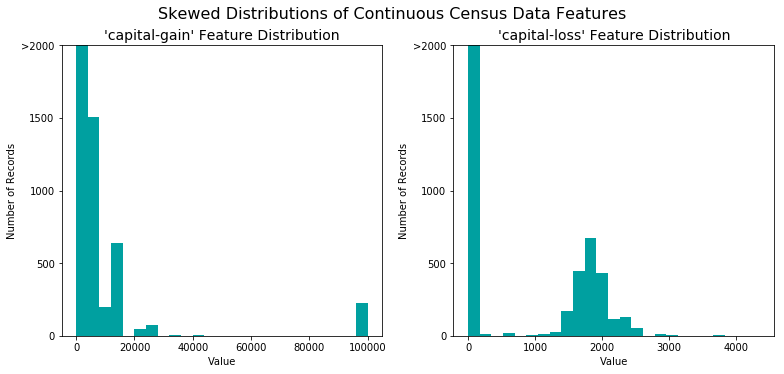

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

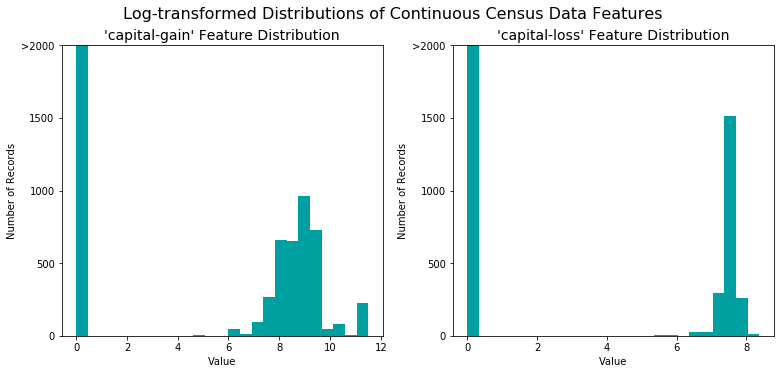

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

In [7]:
features_log_transformed

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.000000,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.000000,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.000000,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.000000,40.0,Cuba
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.000000,40.0,United-States
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.000000,16.0,Jamaica
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.000000,45.0,United-States
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,9.552866,0.000000,50.0,United-States
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,8.552367,0.000000,40.0,United-States


In [8]:
data['capital-gain'].value_counts()

0.0        41432
15024.0      498
7688.0       391
7298.0       351
99999.0      229
3103.0       146
5178.0       137
5013.0       116
4386.0       102
3325.0        81
8614.0        78
2174.0        72
10520.0       64
4650.0        62
27828.0       56
4064.0        52
3137.0        50
14084.0       47
20051.0       44
594.0         42
3908.0        41
6849.0        41
13550.0       40
2829.0        40
4787.0        34
14344.0       34
1055.0        31
3411.0        30
3464.0        30
2597.0        29
           ...  
6767.0         4
34095.0        4
2538.0         4
1424.0         4
991.0          4
4687.0         4
41310.0        3
2050.0         3
2062.0         3
7896.0         3
2228.0         3
6360.0         3
2936.0         3
1455.0         3
1264.0         2
1173.0         2
7978.0         2
2961.0         2
2009.0         2
6097.0         2
18481.0        2
2993.0         2
3432.0         2
5060.0         2
401.0          2
7262.0         1
1639.0         1
22040.0       

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

We are using this scaling(MinMaxScaler) include robustness to very small standard deviations of features and preserving zero entries in sparse data.

Another method for scaling in sklearn.preprocessing is :MaxAbsScaler scales in a way that the training data lies within the range [-1, 1] by dividing through the largest maximum value in each feature. It is meant for data that is already centered at zero or sparse data.

There is also RobustScaler: If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use RobustScaler as a drop-in replacement instead. It uses more robust estimates for the center and range of your data.



In [9]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
#We are normalizing all continues features.

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [10]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


In [11]:
features_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [12]:
# Import train_test_split
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [13]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case.Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step. 
FP = income.count() - TP # Specific to the naive case
TN = 0 # No predicted negatives in the naive case 
FN = 0 # No predicted negatives in the naive case 

'''
TP=float(np.sum(income))
FP=income.count() - TP
TN=0
FN=0
#TODO: Calculate accuracy, precision and recall
accuracy=(TP+TN)/(TP+FP+TN+FN)
recall=TP/(TP+FN)  #1
precision=TP/(TP+FP) #it is equal accuracy

#TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta= 0.5
fscore = (1+beta**2)*(precision*recall)/(beta**2*precision+recall)
#Print the results
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f817ffba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1f816626a0>]], dtype=object)

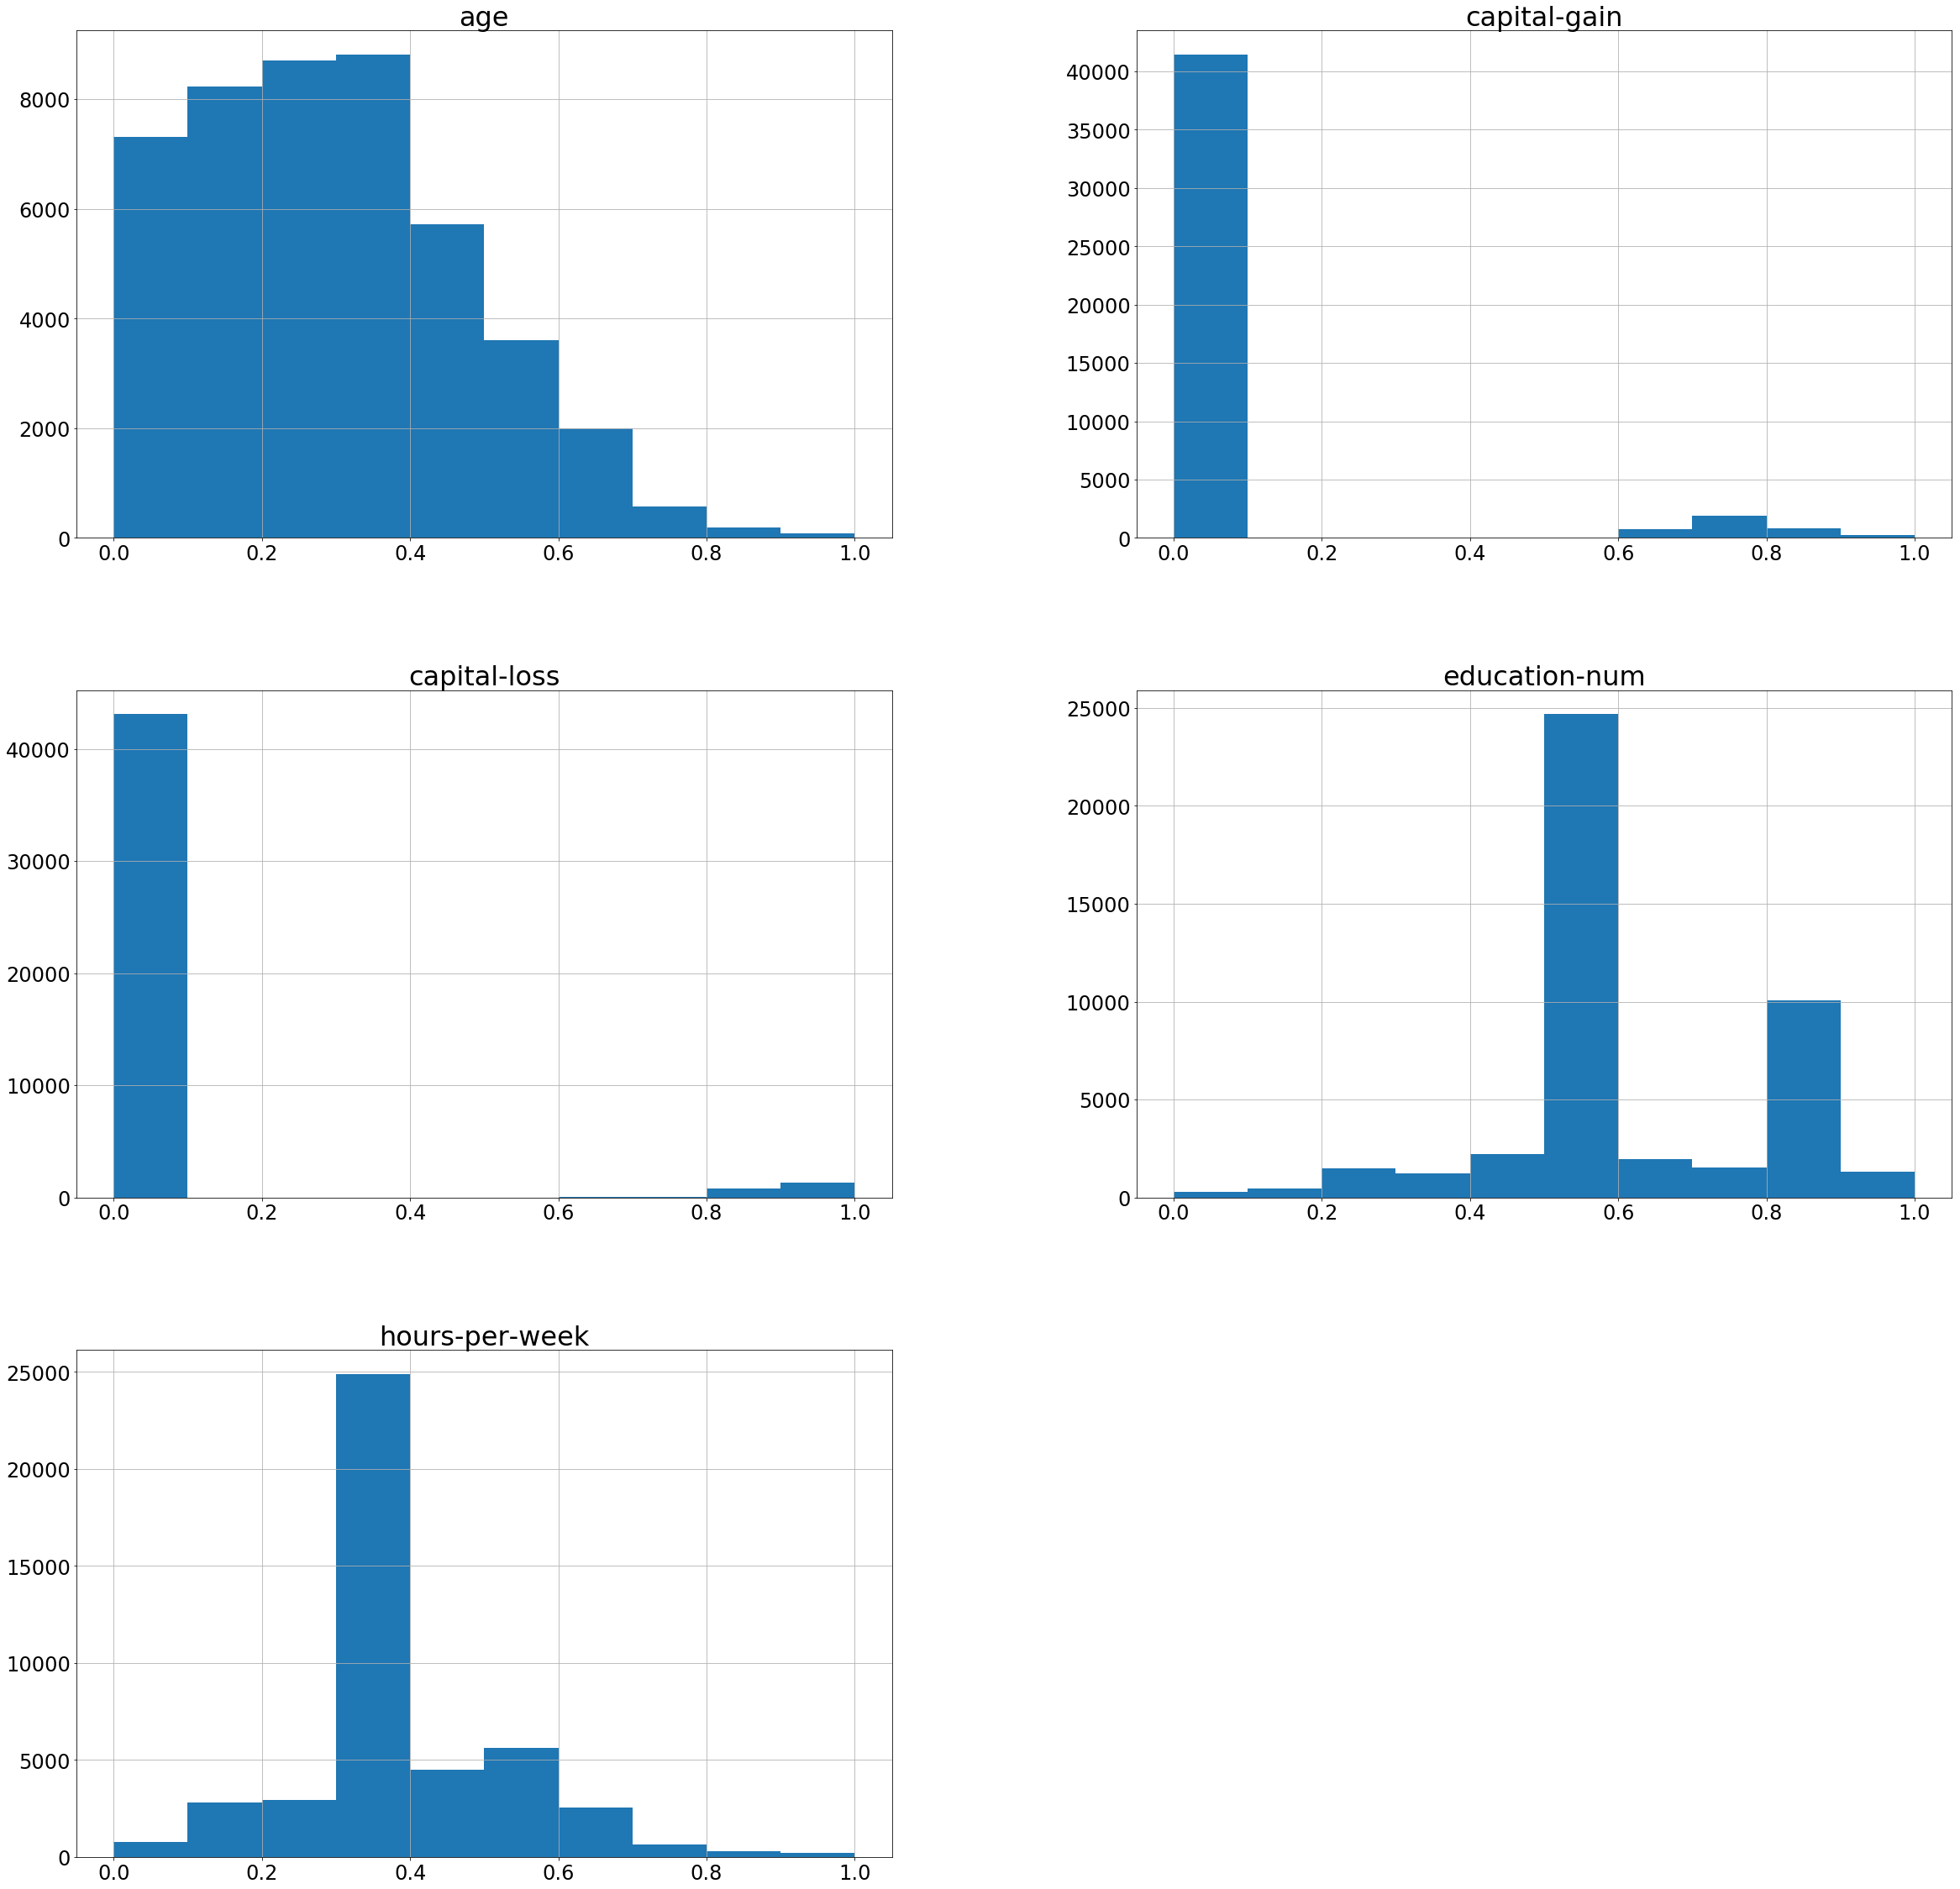

In [14]:
import matplotlib.pyplot as plt
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)
features_log_minmax_transform .hist(figsize=(40, 40))

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

## 1-Random Forest

#### Describe one real-world application in industry where the model can be applied. 
Random Forest is a popular algorithm that has been successfully applied in various industries for solving a wide range of real-world problems. Here's an example of a real-world application of Random Forest:

In the healthcare industry, Random Forest has been used for predicting patient outcomes, such as the likelihood of readmission or mortality. For example, a hospital can use Random Forest to analyze electronic health records of patients and predict which patients are at high risk of readmission, which can help them take proactive measures to prevent readmissions and improve patient outcomes.

In another example, Random Forest has been used in the finance industry for credit risk assessment. Credit risk assessment is a crucial task for banks and other financial institutions, as it helps them evaluate the risk of lending money to a borrower. Random Forest can be used to analyze various factors, such as the borrower's credit history, income, and employment status, and predict the likelihood of default. This can help banks make more informed lending decisions and reduce the risk of default.

In the retail industry, Random Forest has been used for customer segmentation and targeted marketing. By analyzing customer data, such as demographics, purchase history, and browsing behavior, Random Forest can be used to identify customer segments with similar characteristics and predict which products they are likely to purchase. This can help retailers design targeted marketing campaigns and improve customer engagement and loyalty.

Overall, Random Forest is a versatile algorithm that can be applied in many industries for solving various real-world problems, from healthcare and finance to retail and marketing.


#### What are the strengths of the model; when does it perform well?

Random Forest is a powerful and versatile machine learning algorithm that has several strengths and advantages:

Robustness: Random Forest is a robust algorithm that can handle a wide range of data types, including categorical, numerical, and mixed data. It can also handle missing data and noisy data, making it useful in many real-world applications.

Accuracy: Random Forest is known for its high accuracy and robustness to overfitting. By aggregating the predictions of multiple decision trees, Random Forest can reduce the variance and increase the stability of the model, leading to better generalization performance.

Interpretability: Random Forest provides feature importance measures that can help identify the most important variables in the model. This can help interpret and understand the model and make informed decisions.

Efficiency: Random Forest can handle large datasets and high-dimensional feature spaces efficiently. It can also be easily parallelized, making it suitable for distributed computing frameworks like Apache Spark.

Versatility: Random Forest can be used for both classification and regression tasks, and can handle both balanced and unbalanced datasets.

Random Forest performs well in a variety of scenarios, but is particularly effective when:

The dataset has a large number of features or variables, and the relationships between the variables are complex and non-linear.

The dataset contains categorical variables or mixed data types.

The dataset has missing data or outliers.

The goal is to achieve high prediction accuracy while maintaining model interpretability and avoiding overfitting.

The dataset is imbalanced or skewed, and the goal is to predict rare events or anomalies.

Overall, Random Forest is a powerful and versatile algorithm that can be effective in many real-world scenarios, especially when the data is complex or challenging.

#### What are the weaknesses of the model; when does it perform poorly?
While Random Forest is a powerful and versatile algorithm, it also has some limitations and weaknesses:

Complexity: Random Forest can be a complex model that can be difficult to interpret and understand. While feature importance measures can help identify important variables, it may not provide insights into the underlying relationships between variables.

Memory and computation requirements: Random Forest can require a significant amount of memory and computation, particularly when dealing with large datasets or high-dimensional feature spaces.

Overfitting: While Random Forest is generally robust to overfitting, it can still be prone to overfitting in certain cases, such as when the number of features is much larger than the number of instances, or when the decision trees in the forest are too deep or too complex.

Biased towards categorical variables: Random Forest can be biased towards categorical variables with a large number of levels or categories, which can lead to overfitting.

Inefficiency for online learning: Random Forest is not designed for online learning or incremental updates, and requires retraining the model from scratch each time new data is added.

Random Forest can perform poorly in certain scenarios, such as:

When the data is highly structured and linear, such as in linear regression tasks, where other linear models may perform better.

When the data contains a large number of irrelevant features that can increase the noise in the model and lead to overfitting.

When the dataset is too small, Random Forest may not be able to learn enough patterns from the data and may lead to overfitting or underfitting.

When the data contains imbalanced or rare classes, Random Forest may need to be adjusted to account for the class imbalance, such as by adjusting the class weights or using sampling techniques.

Overall, Random Forest is a powerful and effective algorithm, but like any model, it has its limitations and should be used appropriately in the context of the problem at hand.
#### What makes this model a good candidate for the problem, given what you know about the data?

Random Forest is a good candidate for predicting donors who have an income of more than 50,000 dollars for one year for several reasons:

Handling mixed data types: The 1994 US Census dataset may contain mixed data types, including categorical and numerical variables. Random Forest is well-suited to handle such data, as it can handle both types of variables.

Dealing with missing data: The dataset may contain missing data, which can be a common issue in real-world datasets. Random Forest can handle missing data by imputing values or using surrogate splits, making it more robust to such issues.

Handling large datasets: The 1994 US Census dataset is a large dataset with many features. Random Forest can handle large datasets and high-dimensional feature spaces efficiently, which makes it suitable for this problem.

Reducing overfitting: Random Forest can reduce the risk of overfitting, which can be particularly important when working with complex datasets like the 1994 US Census dataset. By aggregating the predictions of multiple decision trees, Random Forest can reduce the variance and increase the stability of the model, leading to better generalization performance.

Providing feature importance measures: Random Forest can provide feature importance measures that can help identify the most important variables in the model. This can help interpret and understand the model and make informed decisions.

Overall, given the characteristics of the 1994 US Census dataset, Random Forest is a good candidate for predicting donors who have an income of more than 50,000 dollars for one year. It can handle mixed data types, missing data, and large datasets, reduce overfitting, and provide feature importance measures that can help interpret the model.




## 2-Support Vector Machines

#### Describe one real-world application in industry where the model can be applied. 

Support Vector Machines (SVM) have been widely used in various industries, including:

Image recognition: SVM has been used in image recognition and classification tasks, such as identifying objects in satellite imagery, medical image analysis, and face recognition. SVMs can be used to classify images by extracting relevant features from the images and training the model to recognize patterns in the data.

Fraud detection: SVMs have been used for fraud detection in the finance industry. SVMs can learn to identify fraudulent transactions by analyzing patterns in the data and detecting anomalies. SVMs can also be used in conjunction with other machine learning techniques, such as clustering and anomaly detection, to improve fraud detection accuracy.

Text classification: SVMs are widely used in natural language processing tasks, such as text classification and sentiment analysis. SVMs can classify text documents into predefined categories, such as spam or not spam, positive or negative sentiment, or news topics. SVMs can learn to recognize patterns in the text data by identifying relevant features, such as word frequencies and sentence structures.

Medical diagnosis: SVMs have been used in medical diagnosis and disease classification tasks. SVMs can learn to recognize patterns in medical data, such as symptoms, test results, and patient history, to diagnose diseases and predict outcomes. SVMs can also be used to identify patients at high risk of developing certain diseases, such as cancer or heart disease.

Overall, SVMs have many real-world applications in various industries, ranging from image recognition to fraud detection to medical diagnosis. SVMs are a powerful and versatile machine learning algorithm that can be used for both classification and regression tasks and can handle both linear and non-linear data.

#### What are the strengths of the model; when does it perform well?

Support Vector Machines (SVMs) have several strengths that make them a popular machine learning algorithm:

Effective in high-dimensional spaces: SVMs can perform well in high-dimensional spaces, making them suitable for solving complex classification and regression problems.

Effective when the number of features is greater than the number of samples: SVMs can handle datasets with more features than samples, which is often the case in real-world applications.

Good generalization performance: SVMs have a low risk of overfitting, which means they can generalize well to new, unseen data.

Flexibility in modeling: SVMs can be used with different kernel functions, which can allow for modeling linear and non-linear decision boundaries.

Effective with small datasets: SVMs can be effective with small datasets, as they can learn from a few examples and generalize well to new data.

Robustness to outliers: SVMs are robust to outliers in the data, which means that they are not strongly influenced by a small number of abnormal data points.

Overall, SVMs perform well in situations where the number of features is high, and the dataset is small or noisy. SVMs are well-suited to handle classification and regression tasks and can be used with different kernel functions to model complex decision boundaries. SVMs have a low risk of overfitting, which means they can generalize well to new data and are a suitable algorithm for a variety of real-world applications.

#### What are the weaknesses of the model; when does it perform poorly?

While Support Vector Machines (SVMs) have several strengths, there are also some weaknesses to consider:

Sensitivity to the choice of kernel function: The performance of SVMs can be highly sensitive to the choice of kernel function. Selecting the wrong kernel can lead to poor performance or overfitting.

Difficulty with large datasets: SVMs can become computationally expensive and slow with large datasets. This can limit their practical applications in situations where data size is an issue.

Difficulty with multiclass classification: SVMs are originally designed for binary classification problems. While they can be extended to handle multiclass classification, this can be more complex and difficult to implement.

No probabilistic output: SVMs do not provide probabilistic outputs, which can make it difficult to interpret the results and estimate confidence levels.

Difficult to tune: SVMs have several parameters, such as the regularization parameter and kernel parameters, that need to be tuned to optimize performance. This tuning process can be time-consuming and challenging.

Overall, SVMs perform poorly in situations where the dataset is large, there are multiple classes to classify, and the optimal choice of kernel function is unclear. SVMs can be computationally expensive and difficult to tune, which can limit their practical applications in some situations.

#### What makes this model a good candidate for the problem, given what you know about the data?

Support Vector Machines (SVMs) can be a good candidate for forecasting a person's income of more than 50,000 dollars for one year for several reasons:

SVMs are effective for binary classification problems: SVMs are originally designed for binary classification problems, which makes them suitable for the task of predicting whether a person's income is above or below 50,000 dollars.

SVMs can handle high-dimensional data: SVMs can handle datasets with many features, which is often the case in financial and economic data.

SVMs can model non-linear decision boundaries: SVMs can use kernel functions to model non-linear decision boundaries, which can be important when trying to capture complex relationships between features and the target variable.

SVMs can handle small and large datasets: SVMs can perform well with both small and large datasets, which can be useful when working with different sizes of data.

Overall, the ability of SVMs to handle high-dimensional data, model non-linear decision boundaries, and perform well with both small and large datasets, make them a good candidate for predicting a person's income of more than 50,000 dollars for one year. Additionally, SVMs have a low risk of overfitting, which can lead to good generalization performance and accurate predictions on new data.

## 2-Logistic Regression
#### Describe one real-world application in industry where the model can be applied. 

Logistic regression is a popular statistical model that is widely used in industry for a variety of applications. One example of a real-world application of logistic regression is in the field of marketing, where it can be used to predict customer churn.

Customer churn refers to the process of customers leaving a company or discontinuing their services. It is a major challenge for businesses as it can lead to a loss of revenue, reduced profitability, and a negative impact on customer satisfaction. By predicting customer churn, companies can take proactive measures to retain customers and prevent losses.

Logistic regression can be used to build a model that predicts the probability of customer churn based on a range of factors such as demographics, past behavior, and customer interactions. By analyzing these factors, the model can identify customers who are most likely to churn and prioritize retention efforts towards them. The model can also help businesses to understand the underlying drivers of churn and develop targeted marketing strategies to prevent it.

Logistic regression can be a valuable tool for businesses in a range of industries, including telecommunications, financial services, and retail. By predicting customer churn, businesses can reduce customer attrition, increase customer loyalty, and ultimately drive revenue growth.

#### What are the strengths of the model; when does it perform well?
Logistic regression has several strengths, including:

Simplicity and interpretability: Logistic regression is a simple and easy-to-understand model that produces interpretable results. The coefficients of the model can be interpreted as the effect of each predictor variable on the probability of the outcome.

Flexibility: Logistic regression can handle a wide range of predictor variables, including both continuous and categorical variables. It can also handle interactions between variables, allowing for more complex relationships to be modeled.

Efficiency: Logistic regression is computationally efficient and can handle large datasets with many predictor variables.

Robustness: Logistic regression is robust to outliers and can handle missing data.

Good performance with small datasets: Logistic regression can perform well with small datasets, making it a good choice when the amount of available data is limited.

Overall, logistic regression performs well in situations where the relationship between the predictor variables and the outcome variable is well understood, and where the data is relatively simple and easy to interpret. It can also perform well when there are a limited number of predictor variables and when the amount of available data is limited.
#### What are the weaknesses of the model; when does it perform poorly?
Logistic regression also has some weaknesses, including:

Limited flexibility: Logistic regression assumes a linear relationship between the predictor variables and the log-odds of the outcome, which can be a limitation in cases where the relationship is more complex or nonlinear.

Sensitivity to outliers: Logistic regression can be sensitive to outliers in the data, which can have a disproportionate effect on the model.

Overfitting: Logistic regression can be prone to overfitting when there are too many predictor variables relative to the size of the dataset.

Assumption of independence: Logistic regression assumes that the predictor variables are independent of each other, which can be a limitation in cases where there are correlations between the variables.

Imbalanced data: Logistic regression can perform poorly when the data is imbalanced, meaning that there are very few instances of one of the outcomes.

Overall, logistic regression can perform poorly in situations where the relationship between the predictor variables and the outcome variable is complex or nonlinear, or when there are correlations between the predictor variables. It can also perform poorly when there are too many predictor variables relative to the size of the dataset, or when the data is imbalanced.

#### What makes this model a good candidate for the problem, given what you know about the data?

Logistic regression is a good candidate for forecasting whether a person has an income of more than 50,000 dollars for one year, given that the outcome variable is binary (income above or below 50,000 dollars) and there are likely several predictor variables that may influence the income level, such as age, education, occupation, and work experience. Logistic regression is a simple and interpretable model that can handle a mix of continuous and categorical predictor variables, and can provide insight into the relative importance of each predictor variable in determining the outcome. Additionally, logistic regression can be robust to outliers and missing data, which may be present in the dataset. However, it is important to carefully evaluate the assumptions of logistic regression, such as the linearity assumption and the independence of predictor variables, before using the model for forecasting.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [15]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


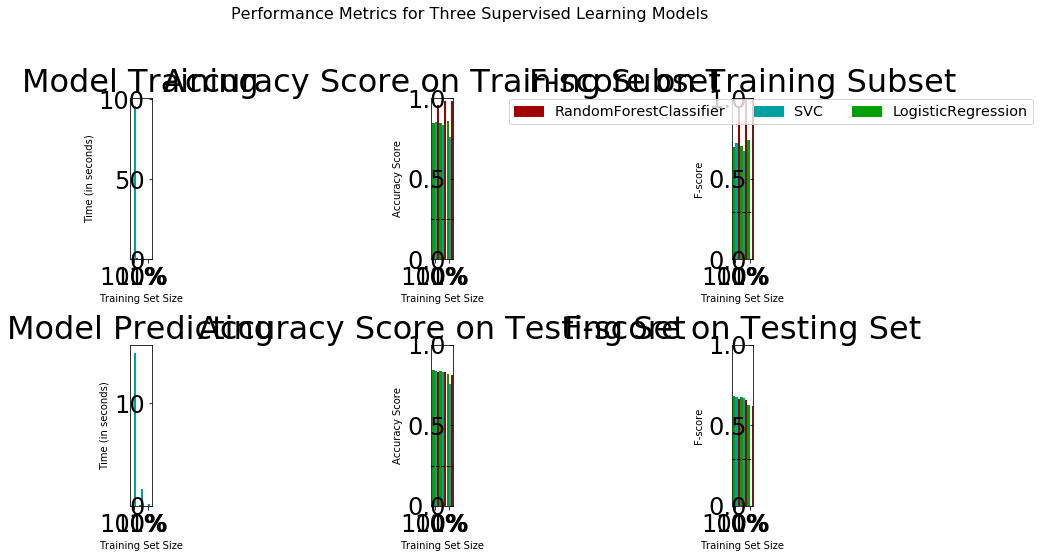

In [16]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, fbeta_score
import warnings
warnings.filterwarnings("ignore")

# TODO: Initialize the three models
random_state = 42
clf_A = RandomForestClassifier()
clf_B =SVC()
clf_C = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_1 = int(len(y_train)/100)
samples_10 = int(len(y_train)/10)
samples_100 = len(y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [17]:
# Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
acc_test,0.816252,0.829961,0.834163
acc_train,0.986667,0.986667,0.960000
f_test,0.622577,0.656894,0.663900
f_train,0.988372,0.988372,0.937500
pred_time,0.017314,0.017031,0.028957
train_time,0.015804,0.046618,0.628369


SVC


,1%,10%,100%
acc_test,0.756219,0.832615,0.837148
acc_train,0.760000,0.833333,0.853333
f_test,0.000000,0.671256,0.674477
f_train,0.000000,0.671296,0.719697
pred_time,0.189770,1.683115,14.942449
train_time,0.009638,0.734919,95.685308


LogisticRegression


,1%,10%,100%
acc_test,0.818684,0.838585,0.841902
acc_train,0.860000,0.846667,0.846667
f_test,0.628860,0.677507,0.683165
f_train,0.738636,0.703125,0.698529
pred_time,0.004272,0.087703,0.003092
train_time,0.003894,0.096138,0.448635


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

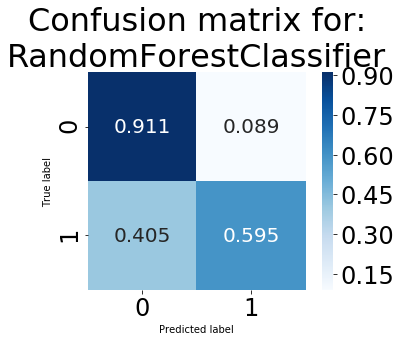

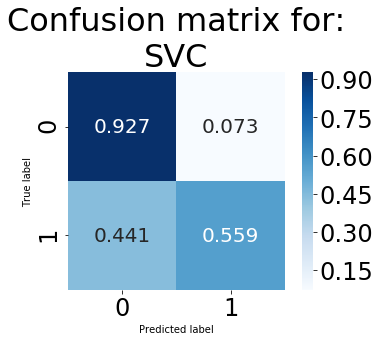

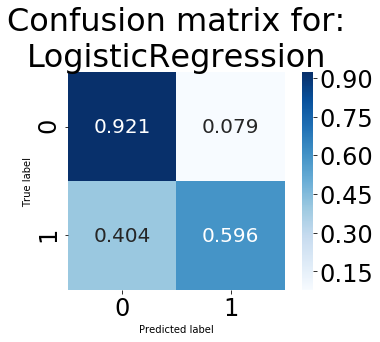

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":20}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

By looking at the above results, Logistic Regression is the most appropriate for the task of identifying individuals that make more than $50,000. This is concluded by considering below mentioned points

If we compare the F score of Random Forest (i.e. 0.669272) with other two models i.e. SVC (0.674477) and Logistic Regression (0.683165), it shows that Logistic Regression outperformed the other two models. Also the above confusion matrix clearly states that the Logistic Regression has the highest prediction accuracy.
Prediction time is considerably low as compare to other models.Although SVC has smilar f score, It has big training time.It is another point to choose Logistic Regression.
Finally, as compare to other models Logistic Regressioon is the best suitable for identifying individuals that make more than $50,000 as it outperformed the other model in Prediction score, F-score and Accuracy.

**Answer: **
Logistic Regression

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 
Logistic regression is a type of statistical analysis used to predict the likelihood of a certain outcome, based on a set of input variables. It is commonly used to analyze and predict binary outcomes, where the result is either a "yes" or "no", or a 1 or 0.

Imagine you want to predict whether or not a student will pass a test, based on factors such as their age, gender, and previous test scores. Logistic regression uses these input variables to create a model that can calculate the probability of the student passing the test.

The output of a logistic regression model is a value between 0 and 1, which represents the probability of the outcome occurring. For example, if the probability is 0.8, it means there is an 80% chance that the student will pass the test.

Logistic regression works by estimating the relationship between the input variables and the outcome variable using a mathematical equation called a logistic function. The logistic function maps the input variables onto a probability scale, which allows us to make predictions about the outcome based on the input variables.

Overall, logistic regression is a useful tool for making predictions and analyzing data in many different fields, such as business, healthcare, and social sciences.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [19]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# TODO: Initialize the classifier
clf = LogisticRegression()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2'],'max_iter': list(range(100,800,100))}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit =  grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6842


In [20]:
best_clf = grid_fit.best_estimator_
print(best_clf)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.8419           |   0.8420              |
| F-score        |        0.6832           |   0.6842       |


**Answer: **
When comparing between the optmized and unoptimized models, the optimized model performs slightly better.



----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
In my opinion, the features that are most important for prediction and my reasoning are ranked and explained below:

1- Age: Younger people are usually less experienced than older people and therefore also paid less.

2- Hours per week: Assuming that two people have the same hourly rate, the one that works more hours has the potential of earning more money and is more likely to be making more than 50K.

3- Education level: People with higher education also have better chances of finding higher paying jobs

4- Workclass: Working for the state or government does not always pay as much as working in the private sector.

5- Native country:People in first world countries, such as USA tend to earn more income that in other countries.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

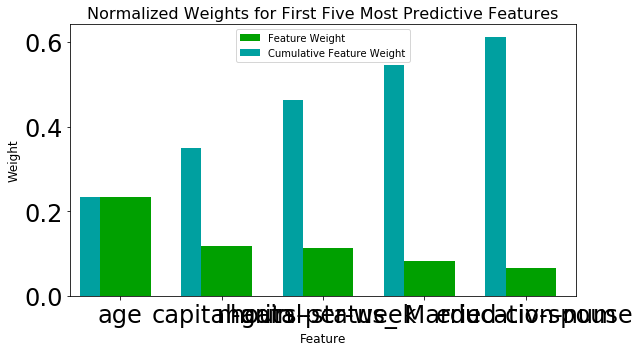

In [21]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
Age, hours per week, capital gain and education-num (numeric value for education) are also considered by the Random Forest Classifier, as the most relevant features to predict an individual makes at most or above $50,000. Marital status which I have not considered to be the important feature seems that people those who are married and living together will have high cumulative income i.e. >50K

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [22]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6842

Final Model trained on reduced data
------
Accuracy on testing data: 0.8271
F-score on testing data: 0.6499


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
In general, reducing the number of features in a logistic regression model can have both positive and negative effects on the F-score and accuracy score. By reducing the number of features, the model may become less complex and overfitting may be reduced. However, reducing the number of features can also result in the loss of important information that could have improved the model's predictive power.

If the F-score and accuracy score on the reduced data using only five features are significantly lower than those same scores when all features are used, it may indicate that the reduced set of features is not sufficient for predicting the target variable accurately. In this case, using the reduced data as the training set may not be a good option, even if training time is a factor.

On the other hand, if the F-score and accuracy score on the reduced data using only five features are comparable to those same scores when all features are used, it may indicate that the reduced set of features is sufficient for predicting the target variable accurately. In this case, using the reduced data as the training set may be a good option, especially if training time is a factor.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [23]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 806330 bytes to finding_donors.html']